In [37]:
import torch
from transformers import AutoTokenizer

import shap
import matplotlib.pyplot as plt

from error_analysis_TRC import load_local_model, prepare_data

In [38]:
ASSIGN_WEIGHT = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cpu"
model_name = 'cardiffnlp/twitter-roberta-large-2022-154m'

model_path = '/home/cc/rora_tesi_new/log/log_TRC/twitter-roberta-large-2022-154m/bertweet-seq/20_epoch/data/True_weight/42_seed/saved-model/pytorch_model.bin'
config_path = '/home/cc/rora_tesi_new/log/log_TRC/twitter-roberta-large-2022-154m/bertweet-seq/20_epoch/data/True_weight/42_seed/saved-model/config.json'

In [39]:
train_data_path = '/home/cc/rora_tesi_new/data/train.p'
test_data_path = '/home/cc/rora_tesi_new/data/test.p'

need_columns = ['tweet','tweet_tokens', 'sentence_class']

tweet_test, tweet_tokens_test, binary_test = prepare_data(test_data_path, need_columns)




In [40]:
tokenizer = AutoTokenizer.from_pretrained(model_name, normalization = True)
model = load_local_model(model_path, config_path, device, model_name)
model = model.to(device)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-large-2022-154m were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [41]:
labels = sorted(model.config.label2id, key=model.config.label2id.get)
print(labels)
labels = [x.split('_')[1] for x in labels]
print(labels)

TypeError: 'list' object is not callable

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# input della funzione una lista di stringhe

def f(x):
    # x = [tweet_test[0]]
    tv = torch.tensor([tokenizer.encode(v, padding='max_length', max_length=128, truncation=True) for v in x]).to(device)
    # print('tv',tv.shape)
    attention_mask = (tv!=0).type(torch.int64).to(device)
    # print('atte',attention_mask.shape)
    model.eval()
    with torch.no_grad():
        outputs = model(tv, attention_mask, class_weight=None)
    # print(outputs)

    return outputs['logits']

In [ ]:
f([tweet_test[0]])

tensor([[ 0.7067, -0.7189]], device='cuda:0')

In [ ]:
inputs = []
for i in range(10):
    inputs.append(tweet_test[i])


In [ ]:
# explainer = shap.Explainer(f, tokenizer, output_names=labels)
explainer = shap.Explainer(f, masker = tokenizer)


In [ ]:
shap_values = explainer(inputs)

Partition explainer: 11it [00:39,  4.38s/it]                        


In [ ]:
shap_values.shape

(10, None, 2)

In [ ]:
# shap_values = shap_values[:,:,1]
# shap_values.shape

In [ ]:
import string

token_dict = {}
def create_token_dict(shap_values):
    val = [shap_values[i] for i in range(len(shap_values))]
    for el in val:
        for i in range(len(el)-1):
            token = el[i].data
            # print(token)
            token = token.strip()
            if token not in string.punctuation and token != 'USER' and token != 'HTTPURL' and token != '...':
                # print(token)
                shap_val = el[i].values
                pos = shap_val[1]
                if token not in token_dict.keys():
                    token_dict[token] = pos
                else:
                    token_dict[token] += pos
    return token_dict
                # PRENDI SOLO VAL RELATIVO ALLA CLASSE POSITIVA
 

    

In [ ]:
token_dict = create_token_dict(shap_values)

In [ ]:
sorted = sorted(token_dict.items(), key = lambda x:x[1], reverse = True)

TypeError: 'list' object is not callable

In [ ]:
sorted_d = dict(sorted)

In [ ]:
sorted_d

{'food': 0.26454263798271616,
 'Been': 0.16861308738589287,
 'C': 0.1500535449013114,
 'poisoning': 0.13658281521250804,
 'driving': 0.11958596333861352,
 'ulin': 0.11651391411821048,
 'Bot': 0.11408102015654246,
 'day': 0.08059069955100616,
 'the': 0.07563085229032569,
 'stomach': 0.05690295994281769,
 'fun': 0.044575752690434456,
 'night': 0.04090440356069141,
 'earlier': 0.033208651033540565,
 '...': 0.02774444967508316,
 'bu': 0.02637890726327896,
 'Novel': 0.025063876062631607,
 'Form': 0.024367443285882473,
 'into': 0.021356435492634773,
 'Of': 0.018470430746674538,
 'last': 0.018160103716784053,
 'rough': 0.01734209433197975,
 'oke': 0.01682628784328699,
 'was': 0.015205284859985114,
 'Ther': 0.012934007282767977,
 'mask': 0.012304215009013813,
 'got': 0.010649645701050758,
 'ended': 0.00875464454293251,
 'went': 0.008653262526624732,
 'or': 0.007947828620672226,
 'flu': 0.006653677672147751,
 'ab': 0.005886296342526163,
 'Thought': 0.005886244401335716,
 'damn': 0.0049978159368

In [ ]:
def get_n(n,token_dict):
    tmp = {}
    for i,k,v in zip(range(n), token_dict.keys(), token_dict.values()):
        tmp[k] = v
    return tmp


In [ ]:
to_plot = get_n(20, sorted_d)

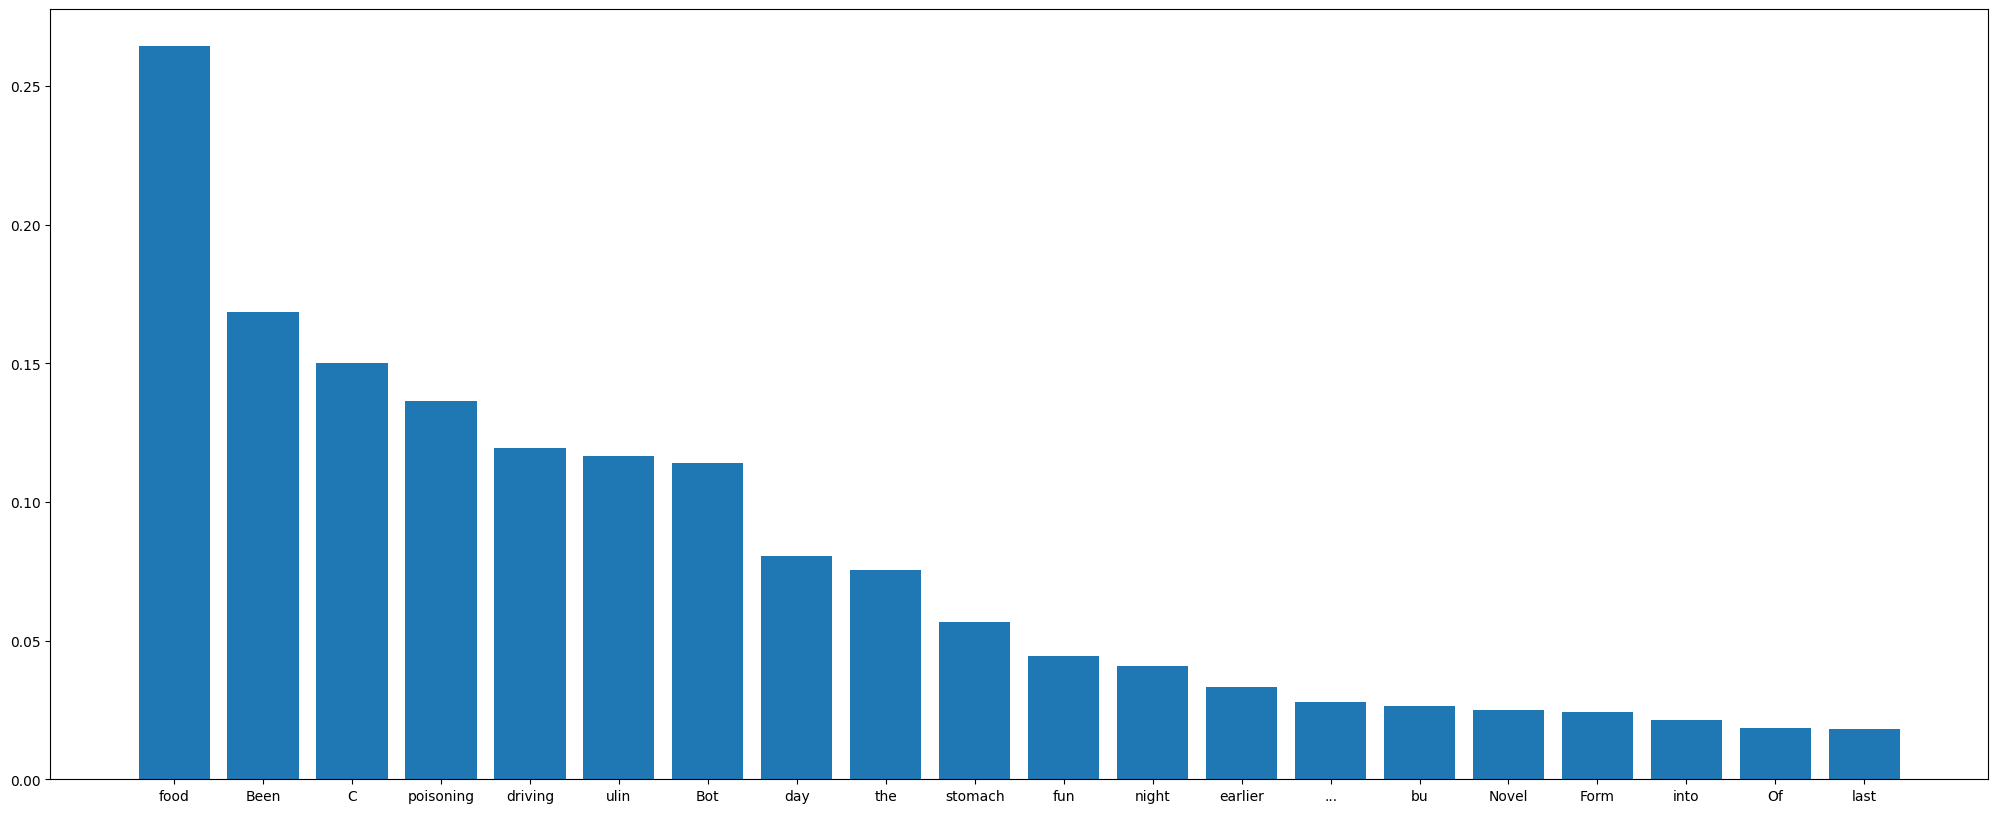

In [ ]:
plt.figure(figsize=(25,10))
plt.bar(range(len(to_plot)), list(to_plot.values()), tick_label=list(to_plot.keys()))
plt.show()

In [ ]:
# [shap_values[i].values.shape for i in range(len(shap_values))]

In [ ]:
# per questo grafico prendi solo scores della classe positiva
# e solo gli scores di un tweet
# shap_values[:,:,1]

# input = [tweet_test[3]]
# sv = explainer(input)
# sv = sv[:,:,1]
# shap.plots.waterfall(sv[0], max_display=20)